# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
* train.csv
* test.csv

#### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

#### Целевая переменная:
Price

#### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Содержание:

In [327]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Дата и время
from datetime import datetime

import random as rnd
rnd.seed(42)

# разбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Вычисление Z-score
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score as r2

In [328]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print(df.dtypes)
    
    return df

Загружаем данные

In [329]:
# Расположение данных
TEST_DATA = './test.csv'
TRAIN_DATA = './train.csv'

In [330]:
train_data = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,184966.93
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,300009.45
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,220925.91
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B,175616.23
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,2078.00,2,4,B,150226.53


In [331]:
train_data.shape

(10000, 20)

In [332]:
test_data = pd.read_csv(TEST_DATA, engine='python', on_bad_lines='skip')
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,4702.00,5,5,B
3,15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


In [333]:
test_data.shape

(5000, 19)

Вывод: Тренировочный датасет содержит 10000 значений, тестовый - 5000

In [334]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Уменьшим объем памяти, которую занимает датасет

In [335]:
train_data = reduce_mem_usage(train_data)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object


In [336]:
# Изменим имя двум признакам
train_data.rename(columns = {'Helthcare_2': 'Healthcare_2',
                             'DistrictId': 'District'}, inplace=True)

### Рассмотрим целевую переменную

In [337]:
train_data['Price'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
10000 non-null  float32
dtypes: float32(1)
memory usage: 39.2 KB


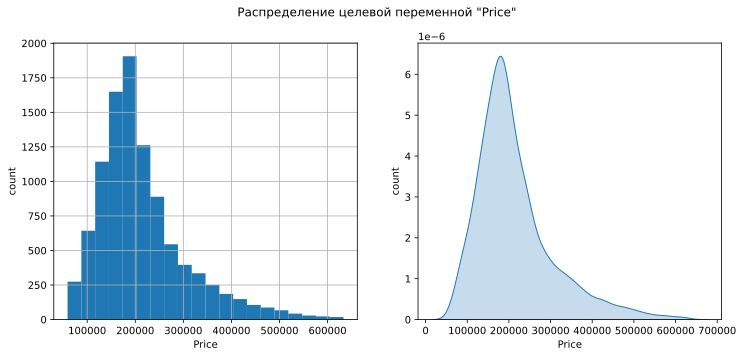

In [338]:
plt.figure(figsize = (12, 5))

plt.subplot(121)
train_data['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_data['Price'], shade=True, legend=False)
plt.ylabel('count')
plt.xlabel('Price')

plt.suptitle('Распределение целевой переменной "Price"')
plt.show()

Вывод: целевая переменная распределена нормально с длинным хвостом справа, сильно заметных выбросов нет

### Рассмотрим набор признаков

In [339]:
# выделим набор признаков в отдельную переменную (он пригодится нам позже)
feature_names = train_data.drop('Price', axis=1).columns

In [340]:
# загрузим информацию о датасете
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   District       10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Healthcare_2   10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Описание данных <a class='anchor' id='description'>
- Id - идентификационный номер квартиры;
- DistrictId - идентификационный номер района;
- Rooms - количество комнат;
- Square - площадь;
- LifeSquare - жилая площадь;
- KitchenSquare - площадь кухни;
- Floor - этаж;
- HouseFloor - количество этажей в доме;
- HouseYear - год постройки дома;
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности;
- Social_1, Social_2, Social_3 - социальные показатели местности;
- Healtcare_1, Heltcare_2 - показатели местности, связанные с охраной здоровья;
- Shops_1, Shops_2 - показатели связанные с наличием магазинов, торговых центров;
- Price - цена квартиры.

In [341]:
# посмотрим статистику по датасету
train_data.describe()

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Price
count,10000.00,10000.00,10000.00,10000.00,7887.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000.00
mean,8383.41,50.40,1.89,56.32,37.20,6.27,8.53,12.61,3990.17,0.12,24.69,5352.16,8.04,1142.90,1.32,4.23,214138.86
std,4859.02,43.59,0.84,21.06,86.24,28.56,5.24,6.78,200500.26,0.12,17.53,4006.80,23.83,1021.52,1.49,4.81,92872.29
min,0.00,0.00,0.00,1.14,0.37,0.00,1.00,0.00,1910.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,59174.78
25%,4169.50,20.00,1.00,41.77,22.77,1.00,4.00,9.00,1974.00,0.02,6.00,1564.00,0.00,350.00,0.00,1.00,153872.63
50%,8394.50,36.00,2.00,52.51,32.78,6.00,7.00,13.00,1977.00,0.08,25.00,5285.00,2.00,900.00,1.00,3.00,192269.65
75%,12592.50,75.00,2.00,65.90,45.13,9.00,12.00,17.00,2001.00,0.20,36.00,7227.00,5.00,1548.00,2.00,6.00,249135.46
max,16798.00,209.00,19.00,641.07,7480.59,2014.00,42.00,117.00,20052011.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00,633233.44


In [342]:
# проверим датасет на дубликаты
duplicates = train_data.duplicated()
train_data[duplicates]

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price


Вывод: дубликатов нет

## Найдем пропущенные значения и заполним их

In [343]:
# найдем пропущенные значения
train_data.isna().sum()

Id                  0
District            0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Healthcare_2        0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Вывод: пропущенные значения есть в двух столбцах 'LifeSquare' и 'Healthcare_1'

#####  **LifeSquare** - жилая площадь

Создадим столбец 'LifeSquare_nan' и заполним его 1, в тех строках, где были пропуски в столбце LifeSquare

In [344]:
train_data['LifeSquare_nan'] = train_data['LifeSquare'].isna() * 1

In [345]:
# пустые значения заменим медианой
train_data['LifeSquare'] = train_data['LifeSquare'].fillna(train_data['LifeSquare'].median())

##### **Healthcare_1**: 'показатели местности, связанные с охраной здоровья 1'

В этом столбце пропусков почти 50%. Такой признак может оказать существенное изменение на оценку модели, поэтому его можно удалить

In [346]:
train_data.drop('Healthcare_1', axis=1, inplace=True)

In [347]:
train_data.isna().sum()

Id                0
District          0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Healthcare_2      0
Shops_1           0
Shops_2           0
Price             0
LifeSquare_nan    0
dtype: int64

Вывод:  больше пропусков нет.

### Визуализируем признаки

Разделим признаки на численные и строковые

In [348]:
def feature_separation(df):
    num_cols = []
    str_cols = []

    cols_and_type = df.dtypes.to_dict()

    for col in cols_and_type:
        if cols_and_type[col] in ('int64', 'float64', 'int16', 'int8', 'int32', 'float32'):
            num_cols.append(col)
        else: 
            str_cols.append(col)
            
    return num_cols, str_cols

In [349]:
num_cols, str_cols = feature_separation(train_data)
f'Числовые признаки: {num_cols}'

"Числовые признаки: ['Id', 'District', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_2', 'Shops_1', 'Price', 'LifeSquare_nan']"

In [350]:
f'Строковые признаки: {str_cols}'

"Строковые признаки: ['Ecology_2', 'Ecology_3', 'Shops_2']"

Для удобства прочтения составим перевод признаков на основе описания данных

In [351]:
translate = {
    'Id': 'идентификационный номер квартиры',
    'District': 'идентификационный номер района',
    'Rooms': 'количество комнат',
    'Square': 'площадь',
    'LifeSquare': 'жилая площадь',
    'KitchenSquare': 'площадь кухни',
    'Floor': 'этаж',
    'HouseFloor': 'количество этажей в доме',
    'HouseYear': 'год постройки дома',
    'Ecology_1': 'экологические показатели местности_1',
    'Ecology_2': 'экологические показатели местности_2',
    'Ecology_3': 'экологические показатели местности_3',
    'Social_1': 'социальные показатели местности_1',
    'Social_2': 'социальные показатели местности_2',
    'Social_3': 'социальные показатели местности_3',
    'Healthcare_1': 'показатели местности, \nсвязанные с охраной здоровья 1',
    'Healthcare_2': 'показатели местности, \nсвязанные с охраной здоровья 2',
    'Shops_1': 'показатели связанные с наличием \n магазинов, торговых центров 1',
    'Shops_2': 'показатели связанные с наличием \nмагазинов, торговых центров 2',
    'Price': 'цена квартиры',
    'LifeSquare_nan': 'пропуски в LifeSquare'
}

### Визуализируем числовые признаки

In [352]:
def visual_num_feature(data, captions):
    plt.figure(figsize=[11, 13])
    # Общий заголовок
    plt.suptitle(f'Распределение числовых признаков',
                    fontsize=16, 
                    fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        
        plt.hist(data[col])

        # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

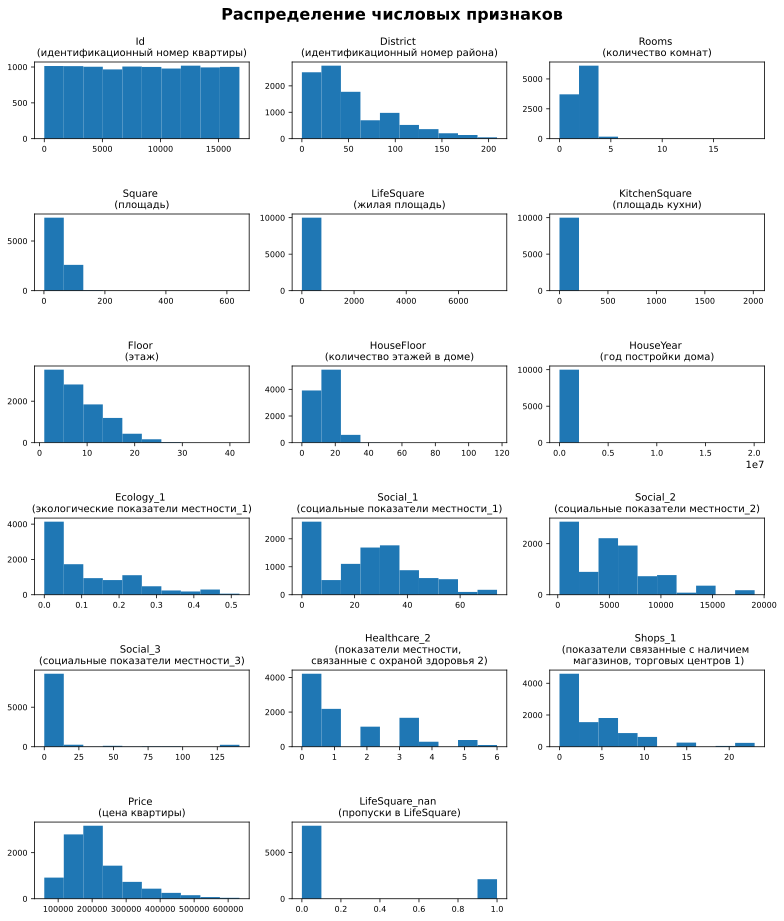

In [353]:
visual_num_feature(train_data, translate)

Вывод: По графикам видно, что есть значительные выбросы почти по всем столбцам. Подробнее каждый столбец рассмотрим ниже

In [354]:
def visual_str_feature(data, captions):
    plt.figure(figsize=[11, 5])

    plt.suptitle(f'Распределение строковых признаков', 
                    fontsize=16, 
                    fontweight='bold')
    
    for i, col in enumerate(str_cols):
        plt.subplot(2, 3, i+1)
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.hist(data[col], bins=2)
    plt.tight_layout()

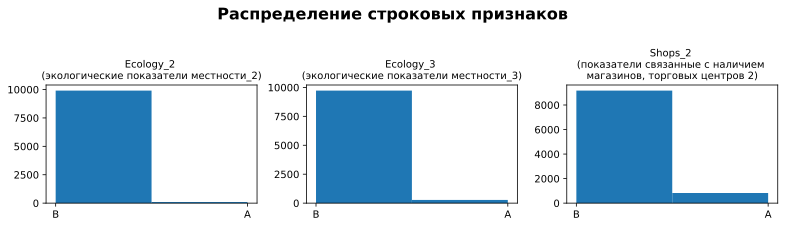

In [355]:
visual_str_feature(train_data, translate)

Вывод: строковые признаки распределены неравномерно, но из-за недостатка информации невозможно оценить значение этих показателей

## Выбросы

### Исследуем столбец **'Rooms'** - количество комнат

In [356]:
# проверим уникальные значения
train_data['Rooms'].unique()

array([ 2.,  3.,  1.,  4., 10.,  0.,  5., 19.,  6.], dtype=float32)

In [357]:
# и количество значений
train_data['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

Вывод: пока очевидно можно сказать, что наблюдаются выбросы по значениям 5, 0, 10, 19, 6

<Axes: ylabel='Rooms'>

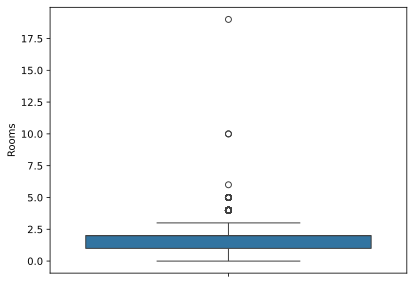

In [358]:
# чтобы убедиться в этом построим ящик с усами
sns.boxplot(train_data['Rooms'])

Вывод:  на графике видно, явный выбросы больше 5 и значения 4 тоже лежат выше 3 квантиля

In [359]:
# посмотрим есть ли квартиры с 5 комнатами и площадью больше 100 - такие квартиры реально могут существовать
train_data[(train_data['Rooms'] == 5) & (train_data['Square'] > 100)]

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
1503,1243,86,5.00,108.06,82.72,8.00,3,5.00,1942,0.16,B,A,31,7010,5,3,7,B,310305.06,0
1982,5548,86,5.00,275.65,233.95,26.00,12,37.00,2011,0.16,B,A,31,7010,5,3,7,B,455264.88,0
3268,8901,34,5.00,121.58,114.91,1.00,25,1.00,1977,0.07,B,B,53,13670,4,1,11,B,455446.41,0
4487,13434,13,5.00,183.38,100.99,15.00,2,6.00,1997,0.09,B,B,74,19083,2,5,15,B,622888.81,0
4762,4070,21,5.00,114.31,88.49,9.00,6,5.00,1960,0.03,B,B,25,5487,3,0,4,B,499830.94,0
5361,2879,78,5.00,118.87,69.02,10.00,15,16.00,1998,0.09,B,B,21,4346,2,1,2,B,496026.66,0
5466,3454,8,5.00,112.14,79.80,10.00,4,17.00,1999,0.44,B,B,23,5735,3,0,5,B,471833.78,0
6623,3294,167,5.00,111.05,81.94,9.00,6,6.00,1940,0.05,B,B,21,4231,14,0,3,B,513239.50,0
6988,8685,62,5.00,124.93,81.12,30.00,5,3.00,2017,0.07,B,B,2,629,1,0,0,A,271919.88,0
8511,4249,23,5.00,198.93,123.14,10.00,1,2.00,2011,0.01,B,B,2,475,0,0,0,B,345665.22,0


Вывод: Да, такие квартиры есть. Тогда за выброс будем считать квартиры меньше 1 комнаты  и больше 5 комнат и площадью меньше 100. Заменим такие значения на медиану

In [360]:
# создадим маску для нашего условия
index_rooms = train_data.query('(Rooms < 1) | ((Rooms >= 5) & (Square < 100))').index
index_rooms

Int64Index([ 377, 1397, 1422, 1454, 1981, 2170, 2269, 3271, 3911, 4366, 4431,
            4853, 6149, 8726, 8834, 8849, 8925],
           dtype='int64')

Сделаем дополнительный признак Rooms_outlier, где со значением 1 укажем строки, соответствующие выбросам в столбце Rooms

In [361]:
train_data['Rooms_outlier'] = 0
train_data.loc[index_rooms, 'Rooms_outlier'] = 1
train_data.head(3)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,...,B,33,7976,5,0,11,B,184966.94,0,0
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,...,B,46,10309,1,1,16,B,300009.44,0,0
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,...,B,34,7759,0,1,3,B,220925.91,0,0


In [362]:
train_data.loc[index_rooms, ['Rooms']] = train_data['Rooms'].median()

### Исследуем столбцы **'Square', 'LifeSquare', 'KitchenSquare'** - все, что связано с площадью

In [363]:
SquareList = ['Square', 'LifeSquare', 'KitchenSquare']

In [364]:
# посмотри что из себя представляют данные
train_data[SquareList].sample(10)

,Square,LifeSquare,KitchenSquare
4664,67.40,5.15,1.00
3240,40.37,22.58,7.00
1576,36.28,22.42,5.00
5893,62.00,45.48,5.00
5010,65.61,32.78,1.00
3225,42.77,29.12,5.00
1231,83.12,81.59,10.00
4592,37.17,23.83,7.00
6958,103.32,67.81,10.00
2918,53.88,32.89,8.00


Вывод: Общая и Жилая площадь представляет число с 6 знаками после запятой, такое врядли встречается в реальной жизни. Округлим эти числа до целого

In [365]:
train_data['Square'] = train_data['Square'].apply(lambda x: np.round(x, 0))
train_data['LifeSquare'] = train_data['LifeSquare'].apply(lambda x: np.round(x, 0))

In [366]:
train_data[SquareList].head(5)

,Square,LifeSquare,KitchenSquare
0,48.00,29.00,6.00
1,66.00,40.00,8.00
2,45.00,29.00,0.00
3,53.00,53.00,9.00
4,40.00,24.00,7.00


In [367]:
# посмотрим статистику по выбранным столбцам
train_data[SquareList].describe()

,Square,LifeSquare,KitchenSquare
count,10000.00,10000.00,10000.00
mean,56.31,36.31,6.27
std,21.06,76.61,28.56
min,1.00,0.00,0.00
25%,42.00,26.00,1.00
50%,53.00,33.00,6.00
75%,66.00,41.00,9.00
max,641.00,7481.00,2014.00


Вывод: Видим аномально большие максимальные значения всех столбцов

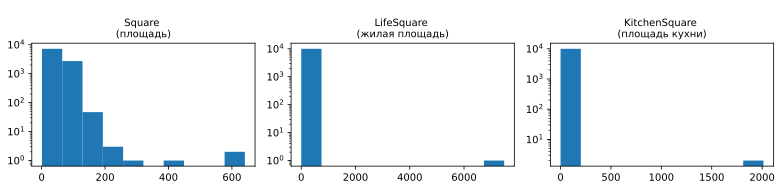

In [368]:
# убедимся в этом, построив гистограммы и применив к ним логарифическую функцию
plt.figure(figsize=[11, 13])

for i, col in enumerate(SquareList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col], log=True)
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)


plt.tight_layout()

Вывод: Большие значения подтверждаются

In [369]:
train_data.Square.median()

53.0

In [370]:
# заменим аномально большие значение и значения меньше 5 на медиану
train_data.loc[((train_data['Square'] > 400) | (train_data['Square'] < 5)), ['Square']] = train_data['Square'].median()

# также заменим значения жилой площади и кухни на медианную, если они больше жилой (т.е 400)
train_data.loc[(train_data['LifeSquare'] > train_data['Square'].max()), ['LifeSquare']] = train_data['LifeSquare'].median()
train_data.loc[(train_data['KitchenSquare'] > train_data['Square'].max()), ['KitchenSquare']] = train_data['KitchenSquare'].median()

посмотрим выбросы на ящике с усами

<Axes: >

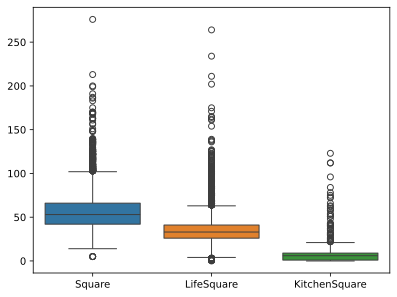

In [371]:
sns.boxplot(train_data[SquareList])

In [372]:
# заменим все значения площади кухни больше 30 на медиану
train_data.loc[(train_data['KitchenSquare'] >= 30), ['KitchenSquare']] = train_data['KitchenSquare'].median()

Так же должны соблюдаться следующие условия:

* Общая площадь > Жилой площади (это очевидно)
* Общая площадь > Площади кухни (аналогично)
* Площадь кухни < Общая площадь - Жилая площадь (еще есть коридор, туалет и балкон)

In [373]:
# Если общая площадь меньше жилой, то ее значение меняем на LifeSquare + KitchenSquare
train_data.loc[(train_data['Square'] <= train_data['LifeSquare']), ['Square']] = train_data['LifeSquare'] + train_data['KitchenSquare']

In [374]:
# Если жилая площадь меньше кухни, то заменим ее на Square - KitchenSquare
train_data.loc[(train_data['LifeSquare'] <= train_data['KitchenSquare']), ['LifeSquare']] = train_data['Square'] - train_data['KitchenSquare']

In [375]:
# заменим площадь кухни, если она больше разницы общей и жилой площадей
train_data.loc[(train_data['KitchenSquare'] > (train_data['Square'] - train_data['LifeSquare'])), ['KitchenSquare']] = train_data['Square'] - train_data['LifeSquare']

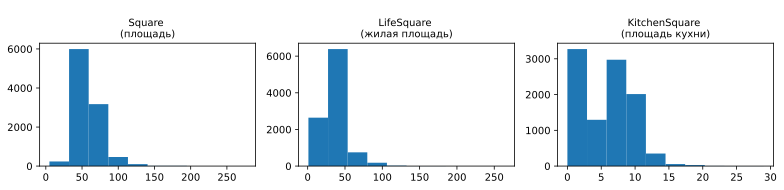

In [376]:
# еще раз посмотри гистограмму
plt.figure(figsize=[11, 13])

for i, col in enumerate(SquareList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col])
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)

plt.tight_layout()

Вывод: хоть данные визуально и не распределены нормально (имеется большой хвост справа), я не считаю нужным дальше подчищать их. Так как квартиры с такими параметрами имеют место быть в реальности

In [377]:
train_data[SquareList].describe()

,Square,LifeSquare,KitchenSquare
count,10000.00,10000.00,10000.00
mean,56.52,35.59,5.55
std,19.32,16.02,3.89
min,5.00,1.00,0.00
25%,42.00,26.00,1.00
50%,53.00,33.00,6.00
75%,66.00,42.00,8.00
max,276.00,264.00,29.00


Вывод: после всех манипуляций с данными столбцами основные статистические данные сильно не изменились (кроме стандартного отклонения, но это из-за изменения максимальных значений)

##### Исследуем столбцы **'Floor'** и **'HouseFloor'**

In [378]:
FloorList = ['Floor', 'HouseFloor']

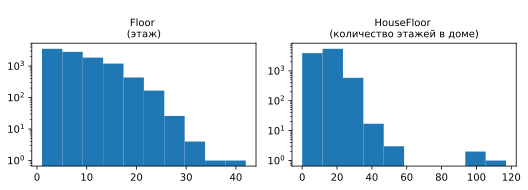

In [379]:
plt.figure(figsize=[11, 13])

for i, col in enumerate(FloorList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col], log=True)
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)

plt.tight_layout()

In [380]:
# посомтрим уникальные значения в обоих столбцах
for el in FloorList:
    print(train_data[el].unique())

[ 7  8 11  5  3 14  9 13  1  6  4 16 12 15 19  2 17 20 10 18 26 23 22 24
 21 25 32 28 27 42 31 37 33]
[  9.  12.  17.   5.   0.   8.   4.  14.  25.   1.  22.  16.  15.   3.
  10.  11.   7.  24.  28.  19.  20.  18.  23.   2.  32.  40.  27.  21.
  13.  45.  30.   6.  37.  48.  47.  44.  39.  36.  29.  99.  38. 117.
  26.  31.]


Вывод: В столбще этажности дома вызывают сомнение значения больше 50 и меньше 1 этажей

In [381]:
# заменим такие значения на медиану
train_data.loc[((train_data['HouseFloor'] > 50) | (train_data['HouseFloor'] < 1)), 'HouseFloor'] = train_data['HouseFloor'].median()

In [382]:
# также стоит проверить значения, где указанный этаж больше количества этажей в доме
index_floor = train_data.loc[(train_data['Floor'] > train_data['HouseFloor']), 'HouseFloor'].index
index_floor

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

Вывод: таких значений 1825 штук

In [383]:
# создадим дополнительный столбец Floor_outlier и заполним его 1, если данное условие верное
train_data['Floor_outlier'] = 0
train_data.loc[index_floor, 'Floor_outlier'] = 1
train_data.head(3)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier
0,14038,35,2.00,48.00,29.00,6.00,7,9.00,1969,0.09,...,33,7976,5,0,11,B,184966.94,0,0,0
1,15053,41,3.00,66.00,40.00,8.00,7,9.00,1978,0.00,...,46,10309,1,1,16,B,300009.44,0,0,0
2,4765,53,2.00,45.00,29.00,0.00,8,12.00,1968,0.05,...,34,7759,0,1,3,B,220925.91,0,0,0


In [384]:
# заменим эти значения на случайное число в соответствие от этажности дома

train_data.loc[index_floor, 'Floor'] = train_data.loc[index_floor, 'HouseFloor'].apply(lambda x: rnd.randint(1, x))

In [385]:
# проверим все ли у нас получилось
train_data[(train_data['Floor'] > train_data['HouseFloor'])]

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier


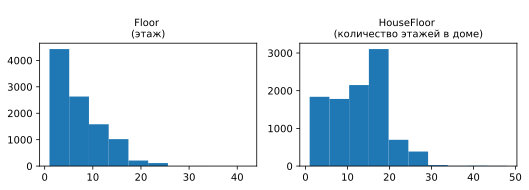

In [386]:
plt.figure(figsize=[11, 13])

for i, col in enumerate(FloorList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col])#, log=True)
    plt.title(f'\n{col} \n({translate[col]})', fontsize=10)

plt.tight_layout()

In [387]:
train_data[FloorList].describe()

,Floor,HouseFloor
count,10000.00,10000.00
mean,7.42,12.93
std,5.03,6.24
min,1.00,1.00
25%,3.00,9.00
50%,6.00,13.00
75%,11.00,17.00
max,42.00,48.00


Вывод: Статистические показатели практически не изменились

##### Исследуем признак **'HouseYear'** - год постройки дома

In [388]:
# Посмотрим даты, которые больше текущей даты 
train_data[train_data['HouseYear'] > datetime.now().year].HouseYear

1497    20052011
4189        4968
Name: HouseYear, dtype: int32

Вывод: таких значений 2. Первое, скорее всего, связано с попыткой указать временной интервал строительства дома, второй - с опечаткой

In [389]:
# поменяем их вручную
train_data.loc[train_data['HouseYear'] == 20052011, 'HouseYear'] = 2011
train_data.loc[train_data['HouseYear'] == 4968, 'HouseYear'] = 1968

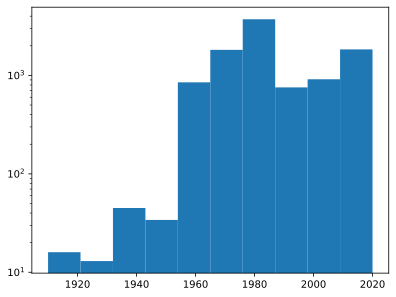

In [390]:
plt.hist(train_data['HouseYear'], log=True)
plt.show()

In [391]:
train_data['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1914       1
1947       1
1916       1
1910       1
1928       1
Name: HouseYear, Length: 95, dtype: int64

In [392]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Id              10000 non-null  int16   
 1   District        10000 non-null  int16   
 2   Rooms           10000 non-null  float32 
 3   Square          10000 non-null  float64 
 4   LifeSquare      10000 non-null  float64 
 5   KitchenSquare   10000 non-null  float32 
 6   Floor           10000 non-null  int64   
 7   HouseFloor      10000 non-null  float32 
 8   HouseYear       10000 non-null  int32   
 9   Ecology_1       10000 non-null  float32 
 10  Ecology_2       10000 non-null  category
 11  Ecology_3       10000 non-null  category
 12  Social_1        10000 non-null  int8    
 13  Social_2        10000 non-null  int16   
 14  Social_3        10000 non-null  int16   
 15  Healthcare_2    10000 non-null  int8    
 16  Shops_1         10000 non-null  int8    
 17  Shops_2      

In [393]:
# изменим тип переменных 
train_data[['Id', 'District']] = train_data[['Id', 'District']].astype(str)

### Создаем класс подготовки исходных данных

In [394]:
class DataPipeline:
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None

    def reduce_mem_usage(self, df):
        """Уменьшение объема памяти"""
        start_mem = df.memory_usage().sum() / 1024**2
        print('Используемая память {:.2f} MB'.format(start_mem))
        
        for col in df.columns:
            col_type = df[col].dtype
            
            if col_type != object:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            else:
                df[col] = df[col].astype('category')

        end_mem = df.memory_usage().sum() / 1024**2
        print('Память после оптимизации: {:.2f} MB'.format(end_mem))
        print('Уменьшено на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print(df.dtypes)
    

    def change_of_type(self, df):
        """Изменение типа переменных и переименование столбцов"""
        df[['Id', 'DistrictId']] = df[['Id', 'DistrictId']].astype(str)
        
        df.rename(columns = {'Helthcare_2': 'Healthcare_2',
                             'DistrictId': 'District'}, inplace=True)
        return df.head(3)
    

    def fit(self, df):
        """Сохранение статистик"""
        self.house_year_mode = df['HouseYear'].mode()[0]
        self.rooms_median = df['Rooms'].median()
        self.square_median = df['Square'].median()
        self.kitchen_square_median = df['KitchenSquare'].median()
        self.life_square_median = df['LifeSquare'].median()
        self.house_floor_median = df['HouseFloor'].median()

    def transform(self, df):
        """Трансформация данных"""
        
        # 1. убираем пропуски
        
        # смотрим пустые значения
        empty_values = df.isna().sum()
        for i, j in empty_values.items():
            # отбираем столбы с пропусками
            if j > 0:
                # если количество пропусков больше 40%, то такой столбец удаляем
                if j / df.shape[0] > 0.3:
                    # значения убираем
                    df.drop(i, axis=1, inplace=True)
                else:
                    # остальное заменяем на медиану
                    df[i+'_nan'] = df[i].isna() * 1
                    df[i] = df[i].fillna(df[i].median())


        # 2. Выбросы (outliers)

        # 'Rooms'
        index_rooms = df.query('(Rooms < 1) | ((Rooms >= 5) & (Square < 100))').index
        df['Rooms_outlier'] = 0
        df.loc[index_rooms, 'Rooms_outlier'] = 1
        df.loc[index_rooms, ['Rooms']] = self.rooms_median

        # 'HouseYear'
        df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = 2011
        df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968

        # 'Square', 'LifeSquare', 'KitchenSquare'
        df['Square'] = df['Square'].apply(lambda x: np.round(x, 0))
        df['LifeSquare'] = df['LifeSquare'].apply(lambda x: np.round(x, 0))

        df.loc[((df['Square'] > 400) | (df['Square'] < 5)), ['Square']] = df['Square'].median()
        df.loc[(df['LifeSquare'] > df['Square'].max()), ['LifeSquare']] = df['LifeSquare'].median()
        df.loc[(df['KitchenSquare'] > df['Square'].max()), ['KitchenSquare']] = df['KitchenSquare'].median()
        df.loc[(df['KitchenSquare'] >= 30), ['KitchenSquare']] = df['KitchenSquare'].median()
        df.loc[(df['KitchenSquare'] >= 30), ['KitchenSquare']] = self.kitchen_square_median
        df.loc[(df['Square'] <= df['LifeSquare']), ['Square']] = df['LifeSquare'] + df['KitchenSquare']
        df.loc[(df['LifeSquare'] <= df['KitchenSquare']), ['LifeSquare']] = df['Square'] - df['KitchenSquare']
        df.loc[(df['KitchenSquare'] > (df['Square'] - df['LifeSquare'])), ['KitchenSquare']] = df['Square'] - df['LifeSquare']

        # 'Floor', 'HouseFloor'
        df.loc[((df['HouseFloor'] > 50) | (df['HouseFloor'] < 1)), 'HouseFloor'] = self.house_floor_median
        rnd.seed(42)
        index_floor = df.loc[(df['Floor'] > df['HouseFloor'])].index
        df['Floor_outlier'] = 0
        df.loc[index_floor, 'Floor_outlier'] = 1
        df.loc[index_floor, 'Floor'] = df.loc[index_floor, 'HouseFloor'].apply(lambda x: rnd.randint(1, x))

        # # 3. Новые фичи (features)
        
        # # Доля спален в общем кол-ве комнат
        # df['bedroom_share'] = df['total_bedrooms'] / df['total_rooms'] * 100

        # # Сколько человек в среднем живут в одной комнате
        # df['population_per_room'] = df['population'] / df['total_rooms']
        
        # # 4. Обработка категорий
        # df = pd.concat([df, pd.get_dummies(df['ocean_proximity'])], axis=1)
        
        return df


### Проверяем работу класса

In [395]:
# подгружаем датасет
train_data_new = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data_new.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,184966.93
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,300009.45
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,220925.91
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B,175616.23
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,2078.00,2,4,B,150226.53


In [396]:
# создаем экземпляр класса
dp = DataPipeline()

In [397]:
# применяем функцию уменьшения памяти
dp.reduce_mem_usage(train_data_new)

Используемая память 1.53 MB
Память после оптимизации: 0.49 MB
Уменьшено на 68.1%
Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object


In [398]:
# изменяем переменные и названия столбцов
dp.change_of_type(train_data_new)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,184966.94
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,300009.44
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,220925.91


In [399]:
# сохоаняем статистики
dp.fit(train_data_new)

In [400]:
# проводим трансформацию данных и сохраняем в новый датафрейм
proverka = dp.transform(train_data_new)

In [401]:
# проверяем на сходство с разобранным датафреймом
proverka.equals(train_data)

True

In [402]:
# проверяем по столбцам (чтобы знать в каком столбце искать ошибку)
for el in train_data.columns:
    print(el, proverka[el].equals(train_data[el]))


Id True
District True
Rooms True
Square True
LifeSquare True
KitchenSquare True
Floor True
HouseFloor True
HouseYear True
Ecology_1 True
Ecology_2 True
Ecology_3 True
Social_1 True
Social_2 True
Social_3 True
Healthcare_2 True
Shops_1 True
Shops_2 True
Price True
LifeSquare_nan True
Rooms_outlier True
Floor_outlier True


Вывод: Написанный класс отработал как надо.

## Построение новых признаков

Предположим, что район влиет на цену квартиры, для этого введем новый признак

In [403]:
# Посмотрим кол-во квартир по разным районам
dc = train_data['District'].value_counts()
dc

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: District, Length: 205, dtype: int64

In [404]:
# сделаем из этих данных датафрейм
# сбросим индексы и заменим названия столбцов
district_count = dc.reset_index().rename(columns={'index': 'District', 'District': 'DistrictCount'})
district_count.head(5)

,District,DistrictCount
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [405]:
# добавим столбец DistrictCount в наш датафрейм путем слияния двух датафреймов по общему столбцу District
train_data = train_data.merge(district_count, on='District', how='left')
train_data.head(5)

,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier,DistrictCount
0,14038,35,2.00,48.00,29.00,6.00,7,9.00,1969,0.09,...,7976,5,0,11,B,184966.94,0,0,0,22
1,15053,41,3.00,66.00,40.00,8.00,7,9.00,1978,0.00,...,10309,1,1,16,B,300009.44,0,0,0,87
2,4765,53,2.00,45.00,29.00,0.00,8,12.00,1968,0.05,...,7759,0,1,3,B,220925.91,0,0,0,174
3,5809,58,2.00,62.00,53.00,9.00,8,17.00,1977,0.44,...,5735,3,0,5,B,175616.23,0,0,0,179
4,10783,99,1.00,40.00,24.00,7.00,11,12.00,1976,0.01,...,5776,1,2,4,B,150226.53,0,0,0,97


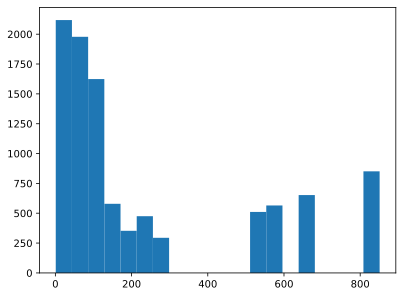

In [406]:
# посмотрим распределение
plt.hist(train_data['DistrictCount'], bins=20);

Вывод: больше всего квартир продается в районах с индексом меньше 100. Вероятно, что эти районы больше по размеру

In [407]:
(train_data['DistrictCount'] < 100).value_counts()

False    5069
True     4931
Name: DistrictCount, dtype: int64

In [425]:
# добавим признак isDistrictLarge, где укажем большой район или нет
train_data['isDistrictLarge'] = 1
train_data.loc[train_data['DistrictCount'] < 100, 'isDistrictLarge'] = 0
train_data.head(3)


,Id,District,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan,Rooms_outlier,Floor_outlier,DistrictCount,isDistrictLarge
0,14038,35,2.00,48.00,29.00,6.00,7,9.00,1969,0.09,...,5,0,11,B,184966.94,0,0,0,22,0
1,15053,41,3.00,66.00,40.00,8.00,7,9.00,1978,0.00,...,1,1,16,B,300009.44,0,0,0,87,0
2,4765,53,2.00,45.00,29.00,0.00,8,12.00,1968,0.05,...,0,1,3,B,220925.91,0,0,0,174,1


Рассмотри матрицу корреляции, чтоб выделить еще несколько новых признаков

In [426]:
corr_m = train_data.corr()

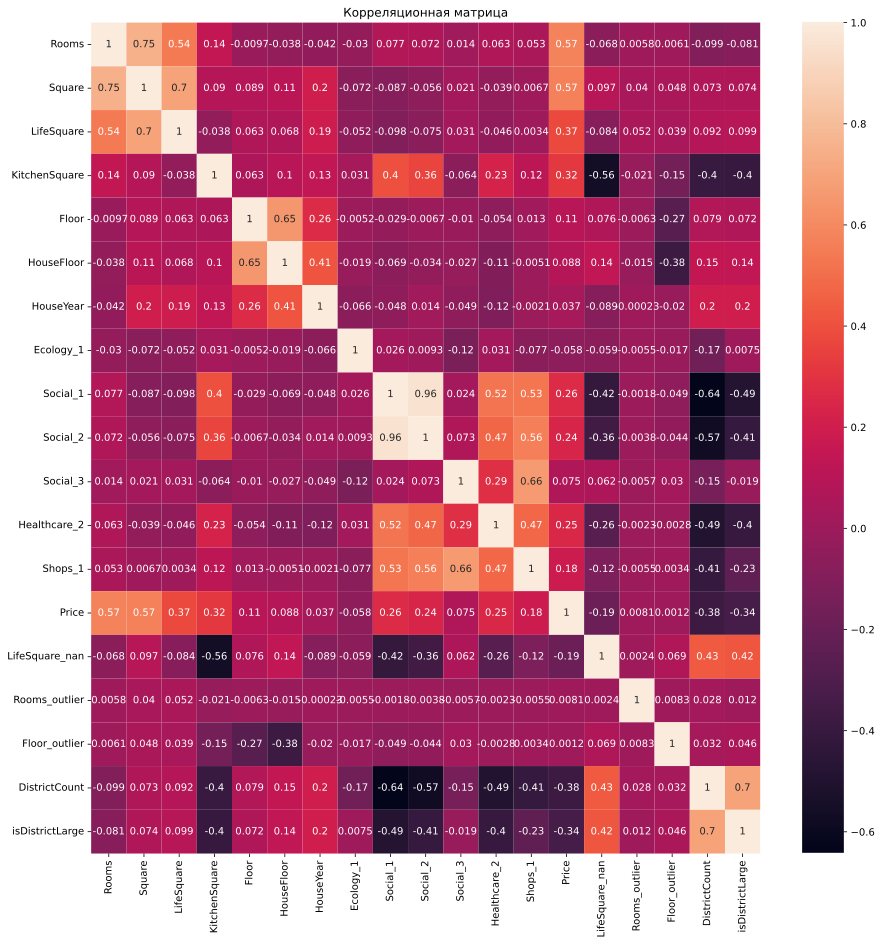

In [427]:
plt.figure(figsize = (15, 15))
plt.title('Корреляционная матрица')
sns.heatmap(corr_m, annot = True)
plt.show()

По матрице корреляции можно сделать следующие выводы:
1) Очевидна зависимость между Кол-во комнат, Площадью и Жилой площадью, а также Этажом от Этажности дома. Также очеведна зависимость Цены квартиры от Площади и Кол-ва комнат
2) Любопытно выделить зависимость Этажности дома от Года его постройки. Факт, который часто остается без внимания
3) Прослеживается зависимость между Social_1, Social_2, Social_3 и Shops_1
4) Если оценивать новые параметры (Кол-во квартир в районе, Размер района), то видно, что они коррелируют с таким признаками как Social_1, Social_2, Healtcare_1, Shops_1 - возможно предположить, что чем больше район, тем развитее в нем инфраструктура.
5) Также есть зависимость Цены от признаков Районов

#### **'MedPriceDistrict'** - средняя цена квартиры по районам

#### **'MedPriceFloorYear''** - средняя цена квартиры в зависимости от Этажности дома и его Года постройки

#### **'isFirstLastFloor'** - первый или последний этаж в доме

In [410]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        # X = X.merge(self.district_size, on='DistrictId', how='left')
        
        # X['new_district'] = 0
        # X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        # X['DistrictSize'].fillna(5, inplace=True)
        
        # X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        # X = self.floor_to_cat(X)  # + столбец floor_cat
        # X = self.year_to_cat(X)   # + столбец year_cat
        
        # # Target encoding
        # if self.med_price_by_district is not None:
        #     X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        #     X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        # if self.med_price_by_floor_year is not None:
        #     X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        #     X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [411]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)

In [412]:
X = train_df.drop('Price', axis=1)
y = train_df['Price']

In [413]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [414]:
preprocessor = DataPipeline()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [415]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [416]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [417]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

In [418]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.96
Test R2:	0.723


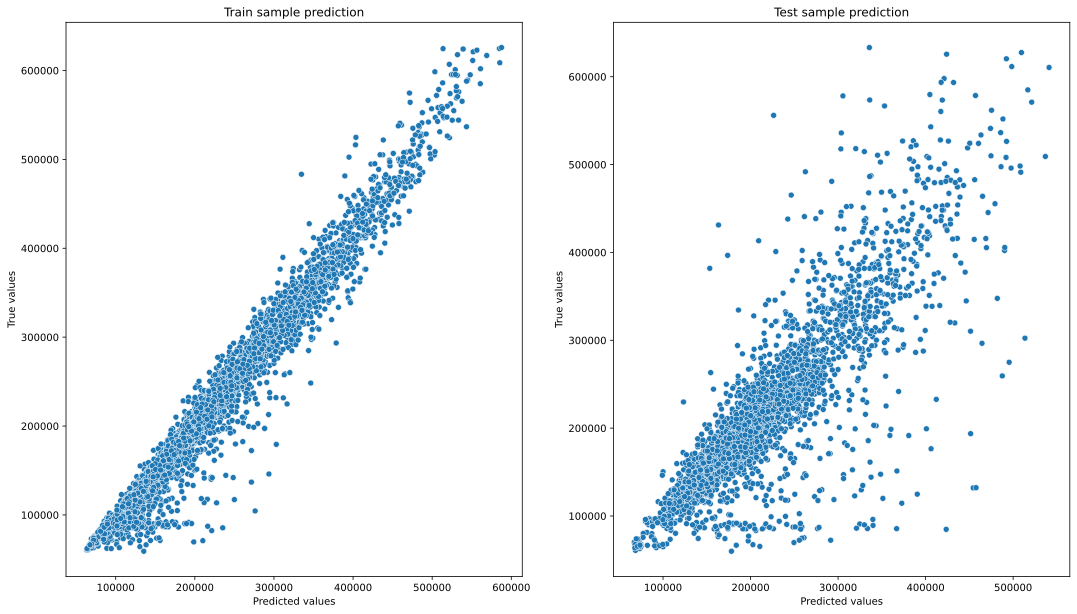

In [419]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [420]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.37
12,Social_1,0.12
2,Rooms,0.08
13,Social_2,0.08
14,Social_3,0.05
1,DistrictId,0.05
9,Ecology_1,0.05
8,HouseYear,0.04
0,Id,0.03
5,KitchenSquare,0.03
